# Automated Microscale Audit of Pedestrian Streetscapes (Auto-MAPS)

This notebook demonstrates how to perform Step 2 of **Auto-MAPS**, a method for automatically conducting a walkability audit using Google Street View (GSV) images and computer vision. To see the full description of the method, refer to [this article](https://doi.org/10.1177/00139165211014609). 

Auto-MAPS uses an implementation of Mask R-CNN by [Matterport](https://github.com/matterport/Mask_RCNN).

## Environment Setting

In [ ]:
# Mound Google Drive
# If you are asked to go to an URL for a key, do so.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone Mask R-CNN from Github
!git clone https://github.com/matterport/Mask_RCNN.git
!git clone https://github.com/BonwooKoo/automated_audit.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 37.96 MiB/s, done.
Resolving deltas: 100% (565/565), done.
Cloning into 'automated_audit'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 185 (delta 47), reused 9 (delta 1), pack-reused 0
Receiving objects: 100% (185/185), 45.04 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
# Change Tensorflow and Keras version
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip uninstall h5py

!pip install tensorflow-gpu==1.15.0
!pip install keras==2.1.6
!pip install h5py==2.10.0

# Downloading the Trained Weights from Koo (2021)

In [ ]:
import os
import sys
# import random
# import math
import urllib
# import numpy as np
import pandas as pd
# import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import shutil
import time
import random
import skimage

# Root directory of the project
MASK_RCNN_DIR = os.path.abspath("/content/Mask_RCNN") # Assuming using Google Colab
AUTO_AUDIT_DIR = os.path.abspath("/content/automated_audit") # Assuming using Google Colab

# Import Mask RCNN
sys.path.append(MASK_RCNN_DIR)  
sys.path.append(AUTO_AUDIT_DIR)
from mrcnn import utils
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import visualize
# Import automated audit dataset class
from automated_audit.Step2.auto_audit import auto_audit_df
# Import COCO config
sys.path.append("/content/Mask_RCNN/samples/coco/")  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
TRAINED_MODEL_PATH = "/content/Mask_RCNN"

WEIGHT_NAME = ["mask_rcnn_crossing.h5", "mask_rcnn_segment_vertical.h5", "mask_rcnn_segment_horizontal.h5"]

WEIGHT_CROSSING = os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[0])
WEIGHT_SEGMENT_V = os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[1])
WEIGHT_SEGMENT_H = os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[2])

missing_weight = os.path.exists(WEIGHT_CROSSING), os.path.exists(WEIGHT_SEGMENT_V), os.path.exists(WEIGHT_SEGMENT_H)
if sum(missing_weight) is not 3:
  missing_weight_index = [i for i, x in enumerate(missing_weight) if x == False]
  TRAINED_WEIGHTS_ID = ["https://www.dropbox.com/s/t0hr2wp67ydneyx/mask_rcnn_crossing.h5?dl=1",
                        "https://www.dropbox.com/s/iobsipv8q23zk9m/mask_rcnn_segment_vertical.h5?dl=1",
                        "https://www.dropbox.com/s/x4jb0ectwghq49v/mask_rcnn_segment_horizontal.h5?dl=1"]
  # # Google Drive version
  # for i in missing_weight_index:
  #   TARGET_FOLDER = os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[i])
  #   d = zdrive.Downloader()
  #   d.downloadFolder(TRAINED_WEIGHTS_ID[i], destinationFolder = TARGET_FOLDER)
  
  for i in missing_weight_index:
    print("Downloading " + WEIGHT_NAME[i] + " to " + TRAINED_MODEL_PATH + " ...")
    u = urllib.request.urlopen(TRAINED_WEIGHTS_ID[i])
    TARGET_FOLDER = os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[i])
    data = u.read()
    u.close()

    with open(TARGET_FOLDER, "wb") as f:
      f.write(data)

Using TensorFlow backend.


## Configuration

In [ ]:
# Define number of classes for each model
NUM_CLASSES = {"crossing": 10, "segment_v": 3, "segment_h": 21}

# Config class
class DenseInference_Config(Config):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  IMAGE_MIN_DIM = 640
  DETECTION_MIN_CONFIDENCE = 0.7
  DETECTION_NMS_THRESHOLD = 0.3
  
  def __init__(self, num_classes, name):
      self.NUM_CLASSES = num_classes
      self.NAME = name
      super().__init__()

class IntersectionInference_Config(Config):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  IMAGE_MIN_DIM = 640
  DETECTION_MIN_CONFIDENCE = 0.8
  DETECTION_NMS_THRESHOLD = 0.1
  
  def __init__(self, num_classes, name):
      self.NUM_CLASSES = num_classes
      self.NAME = name
      super().__init__()


# Crossing Instance
config_crossing = IntersectionInference_Config(num_classes = NUM_CLASSES['crossing'], name = "crossing")
# Segment_v Instance
config_segment_v = DenseInference_Config(num_classes = NUM_CLASSES['segment_v'], name = "segment_v")
# Segment_h Instance
config_segment_h = DenseInference_Config(num_classes = NUM_CLASSES['segment_h'], name = "segment_h")
config_segment_h.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                33
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Model Creation and Loading Trained Weights

In [ ]:
# Create model object in inference mode.
model_crossing = modellib.MaskRCNN(mode="inference", model_dir= TRAINED_MODEL_PATH, config=config_crossing)
model_segment_v = modellib.MaskRCNN(mode="inference", model_dir=TRAINED_MODEL_PATH, config=config_segment_v)
model_segment_h = modellib.MaskRCNN(mode="inference", model_dir=TRAINED_MODEL_PATH, config=config_segment_h)

# Load weights 
model_crossing.load_weights(os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[0]), by_name=True)
model_segment_v.load_weights(os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[1]), by_name=True)
model_segment_h.load_weights(os.path.join(TRAINED_MODEL_PATH, WEIGHT_NAME[2]), by_name=True)

## Create an instance of auto_audit_df class and import point information

In [ ]:
# Import data
AUDIT_POINT_PATH = "/content/automated_audit/sample/audit_point.csv"
DOWNLOAD_PATH = "/content/drive/MyDrive/auto_audit_example/downloaded_images"

# Read audit_point file
audit_point = pd.read_csv(AUDIT_POINT_PATH)

# Initiate the dataset class
auto_audit_init = auto_audit_df()

# Add images to the dataset instance
auto_audit_init.add_image_info(audit_point)

## Download Street View Images

If you have not acquired your images, use the function below with your API Key to get images.

In [ ]:
# # Download images
# auto_audit_init.download_gsv(download_path = DOWNLOAD_PATH, api_key = "your-api-key-here")

## Run Object Detection

In [ ]:
# Predict 
auto_audit_init.predict(DOWNLOAD_PATH, model_segment_h, model_crossing, model_segment_v)

## Calulate Statistics for Each Segment

In [ ]:
# Summary of the prediction
output = auto_audit_init.prediction_summary()
current_time = time.strftime("%Y%m%d-%H%M%S")
OUTPUT_FILENAME = os.path.join(DOWNLOAD_PATH, "prediction_summary-" + current_time + ".csv")
output.to_csv(OUTPUT_FILENAME)

## Additionally, Visualize the result

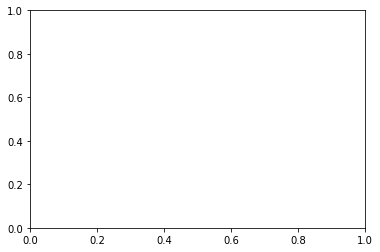

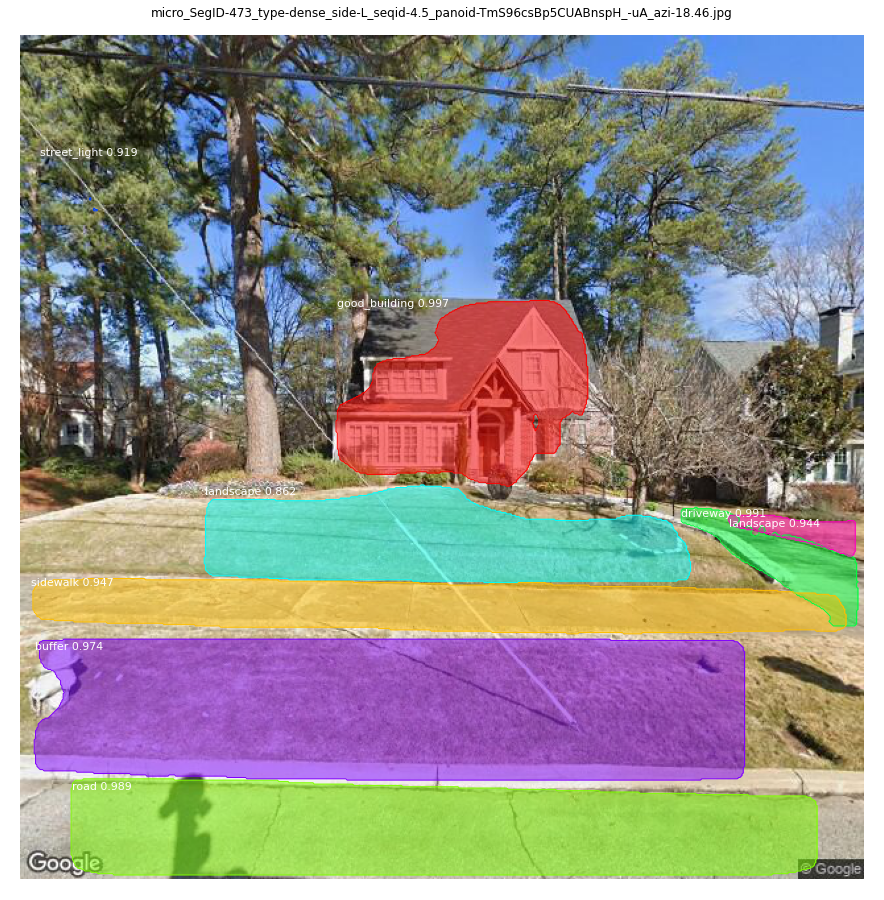

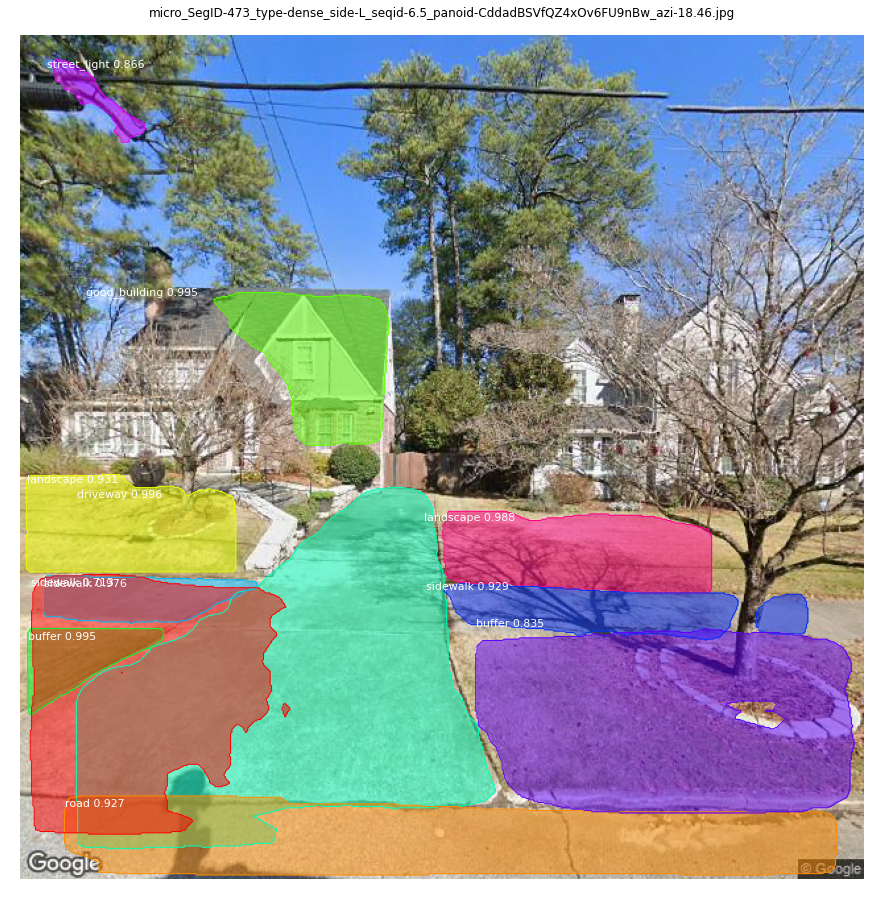

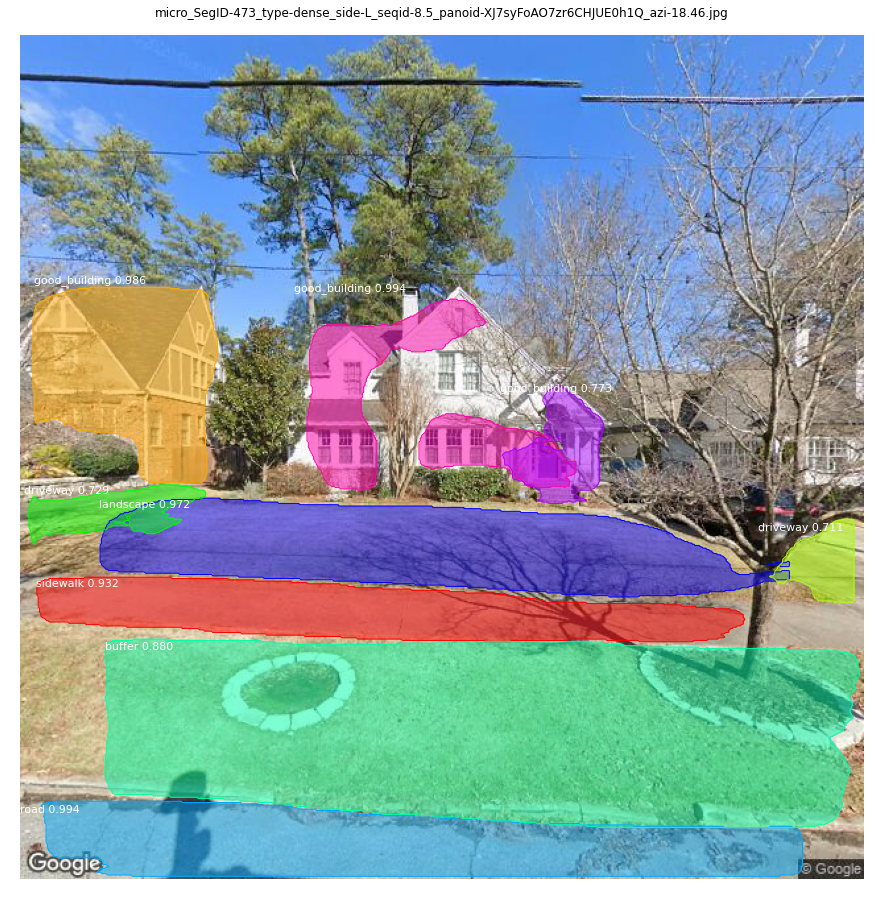

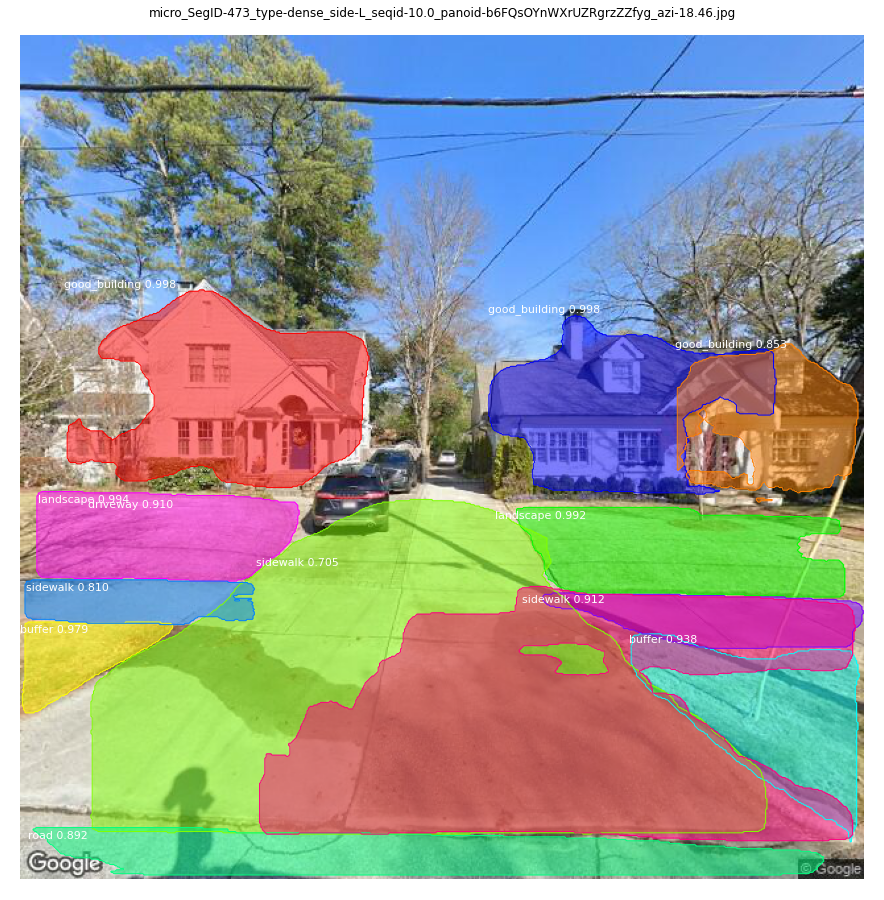

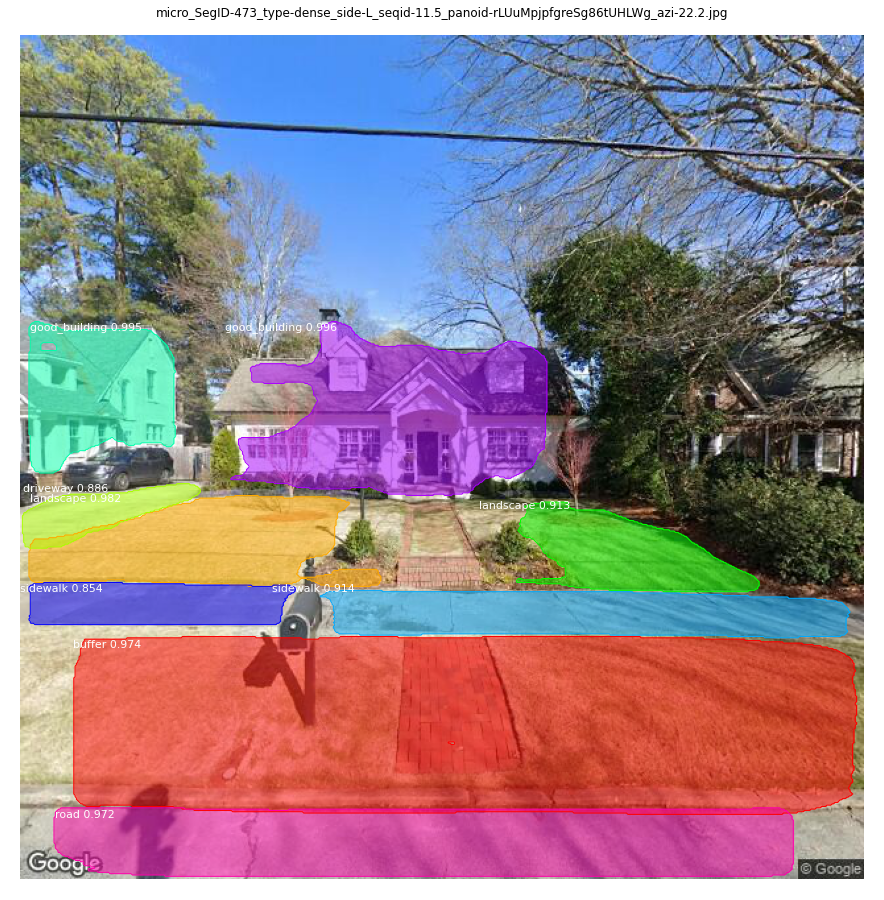

In [118]:
# Display first 5 images
for id in range(5):
  pred = auto_audit_init.get_image_info_by_id(id)["prediction"]  
  ty = list(pred.keys())[0]
  full_path = os.path.join(DOWNLOAD_PATH, pred[ty][0])
  image = skimage.io.imread(full_path)
  yhat = pred[ty][1][0]

  ax = plt.gca()
  r = yhat
  _, ax = plt.subplots(1,1,figsize=(16,16))
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              list(auto_audit_init.class_code_dense.values()), r['scores'], ax = ax, title = pred[ty][0], show_bbox = False)